# Local quadratic acq model 2023-05

This notebook defines a "local quadratic" acquisition probability model.

For each point on 3-d grid of `mag`, `t_ccd` and `halfwidth`, this model fits a
hyper-paraboloid to nearby data (within +/- 2 grid points inclusive)::

    dmag = mag - mag0
    dt_ccd = t_ccd - t_ccd0
    dhalfwdith = halfwidth - halfwidth0

    p_probit = (
        p0 * dmag + p1 * dmag**2 
        + p2 * dt_ccd + p3 * dt_ccd**2
        + p4 * dhalfwidth + p5 * dhalfwidth**2
        + p6
    )

The 3-d grid of points is defined by the sampling in the 2022-Dec ASVT test data::

    mag       : 8.  9.  9.5  9.75 10.  10.25 10.5  10.75 (mag)
    t_ccd     : -15 -13 -11  -9  -8  -7  -6  -5  -4  -3  -2  0  2 (degC)
    halfwidth : 60  80 100 120 140 160 (arcsec)

This uses the 2022-Dec ASVT data set with MAXMAG clipped along with flight data
from 2019-July-01 (approx start time of MAXMAG clipping in flight products).

Reference page:
https://occweb.cfa.harvard.edu/twiki/bin/view/Aspect/PeaAcqModelCalDec2022Testing

In [1]:
import sys
import os
sys.path.insert(0, os.path.expanduser('~/git/chandra_aca'))

from pathlib import Path
from collections import Counter
import itertools
import warnings

import numpy as np
from scipy import stats
from scipy.stats import binom
from scipy import optimize
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from matplotlib import patches
import tables
from cxotime import CxoTime
from chandra_aca import star_probs
import agasc
from chandra_aca.star_probs import binom_ppf
import matplotlib.style

from utils_stats import flatten_pea_test_data, read_twiki_csv, get_acq_stats_data

matplotlib.style.use('bmh')
%matplotlib inline

In [2]:
SKA = Path(os.environ["SKA"])
MODEL_DATE = "2023-05"


In [3]:
AXIS_LABELS = ["mag", "t_ccd", "halfwidth"]


In [4]:
# Read the 2022:236 data from the TWiki

topic = "PeaAcqModelCalDec2022Testing/"
name = "pea_analysis_2022_336_AcqProbModel_calibration_test_results.csv"
dat8 = read_twiki_csv(topic + name)


In [5]:
# Convert to a format that is more convenient for analysis

asvt = flatten_pea_test_data(dat8)
# Rename to conventions of acq stats database
asvt.rename_column("star_mag", "mag_aca")
asvt.rename_column("ccd_temp", "t_ccd")
asvt.rename_column("search_success", "obc_id")
asvt.rename_column("search_box_hw", "halfwidth")
# Coerce uint8 columns (which are all actually bool) to bool
asvt["obc_id"] = asvt["obc_id"].astype(bool)
asvt.info


<Table length=22464>
        name         dtype 
------------------- -------
            test_id float64
           rand_ind   int64
           ref_time   int64
          ref_obsid   int64
       y_ang_offset   int64
       z_ang_offset   int64
          halfwidth   int64
              t_ccd   int64
            mag_aca float64
           star_row float64
           star_col float64
        slot_box_hw   int64
            star_sz   int64
      bg_row_offset   int64
      bg_col_offset   int64
           scale_4c float64
           int_time float64
  hot_px_brightness   int64
         maxmag_cap float64
             maxmag float64
          image_fcn   int64
          image_row   int64
          image_col   int64
max_num_search_hits   int64
        sample_time float64
             obc_id    bool
        star_maxmag float64
               slot   int64

In [6]:
Counter(asvt["t_ccd"])


Counter({-15: 1728,
         -13: 1728,
         -11: 1728,
         -9: 1728,
         -8: 1728,
         -7: 1728,
         -6: 1728,
         -5: 1728,
         -4: 1728,
         -3: 1728,
         -2: 1728,
         0: 1728,
         2: 1728})

In [7]:
Counter(asvt["mag_aca"])


Counter({8.0: 2808,
         9.0: 2808,
         9.5: 2808,
         9.75: 2808,
         10.0: 2808,
         10.25: 2808,
         10.5: 2808,
         10.75: 2808})

In [12]:
# Read flight acquisition stats data and remove color=1.5 stars that have a different
# acquisition model due to a different mag error distribution.
flt = get_acq_stats_data()
ok = ~np.isclose(flt["color"], 1.5)
flt = flt[ok]


In [13]:
flt.info

<Table length=56160>
   name    dtype 
--------- -------
   tstart float64
    obsid   int64
   obc_id    bool
halfwidth   int64
  mag_aca float64
  mag_obs float64
    color float64
 img_func  bytes7
  ion_rad    bool
  sat_pix    bool
 agasc_id   int64
    t_ccd float64
     slot   int64
     year float32
  quarter float32

In [14]:
# Update mag_aca using AGASC 1.8 rc1.
agasc_file = Path(os.environ["SKA"]) / "data" / "agasc" / "agasc1p8rc1.h5"
stars = agasc.get_stars(
    flt["agasc_id"], use_supplement=False, agasc_file=str(agasc_file)
)
flt["mag_aca"] = stars["MAG_ACA"]

In [15]:
# Combine the ASVT and flight data, taking only common columns
flt_asvt = vstack([flt, asvt], join_type="inner")
flt_asvt.info


<Table length=78624>
   name    dtype 
--------- -------
   obc_id    bool
halfwidth   int64
  mag_aca float64
    t_ccd float64
     slot   int64

In [16]:
def get_vals_and_bins(vals):
    """
    For a set of values, return sorted unique values and bin edges.

    Bin edges are centered on the unique values and have an extra bin
    at the start and end to cover the full range of values.
    """
    out_vals = np.array(sorted(set(vals)))
    out_val_centers = (out_vals[1:] + out_vals[:-1]) / 2
    out_val_bins = np.concatenate(
        [
            [out_vals[0] - 0.5],
            out_val_centers,
            [out_vals[-1] + 0.5],
        ]
    )
    return out_vals, out_val_bins


In [17]:
t_ccd_vals, t_ccd_bins = get_vals_and_bins(asvt["t_ccd"])
mag_vals, mag_bins = get_vals_and_bins(asvt["mag_aca"])
halfwidth_vals, halfwidth_bins = get_vals_and_bins(asvt["halfwidth"])


In [18]:
X_VALS = [mag_vals, t_ccd_vals, halfwidth_vals]


In [19]:
from chandra_aca import star_probs
print(star_probs.DEFAULT_MODEL)

def get_flight_model_probs():
    
    mag_grid, t_ccd_grid, halfwidth_grid = np.meshgrid(
        mag_vals, t_ccd_vals, halfwidth_vals, indexing="ij"
    )
    p_succ_flt = star_probs.acq_success_prob(
        date="2023:001", mag=mag_grid, t_ccd=t_ccd_grid, halfwidth=halfwidth_grid
    )
    return p_succ_flt

grid-floor-2020-02


In [20]:

def get_samples_successes(dat, mag_bins, t_ccd_bins, halfwidth_bins):
    """
    Aggregate binned number of samples and successes for ASVT data.

    Take the table of acquisition samples and return two 3-d arrays (mag, t_ccd,
    halfwidth):

    - n_samp: number of samples in each bin
    - n_succ: number of successes in each bin
    """
    zeros = np.zeros(
        shape=(len(mag_bins) - 1, len(t_ccd_bins) - 1, len(halfwidth_bins) - 1),
        dtype=int,
    )
    n_samp = zeros.copy()
    n_succ = zeros.copy()

    # Bin halfwidths (narrow since ASVT data are all at the same mag, T_ccd)
    for ii, mag0, mag1 in zip(itertools.count(), mag_bins[:-1], mag_bins[1:]):
        ok0 = (dat["mag_aca"] >= mag0) & (dat["mag_aca"] < mag1)
        for jj, t_ccd0, t_ccd1 in zip(
            itertools.count(), t_ccd_bins[:-1], t_ccd_bins[1:]
        ):
            ok1 = (dat["t_ccd"] >= t_ccd0) & (dat["t_ccd"] < t_ccd1)
            for kk, halfwidth0, halfwidth1 in zip(
                itertools.count(), halfwidth_bins[:-1], halfwidth_bins[1:]
            ):
                ok2 = (dat["halfwidth"] >= halfwidth0) & (dat["halfwidth"] < halfwidth1)
                ok = ok0 & ok1 & ok2
                n_samp[ii, jj, kk] = np.count_nonzero(ok)
                n_succ[ii, jj, kk] = np.count_nonzero(dat["obc_id"][ok])

    return n_samp, n_succ

In [21]:
n_samp, n_succ = get_samples_successes(
   flt_asvt, mag_bins, t_ccd_bins, halfwidth_bins
)

In [22]:
n_samp.shape

(8, 13, 6)

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p_succ_flt = get_flight_model_probs()

In [24]:
print(mag_vals)
print(mag_bins)


[ 8.    9.    9.5   9.75 10.   10.25 10.5  10.75]
[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


In [25]:
print(t_ccd_vals)
print(t_ccd_bins)


[-15 -13 -11  -9  -8  -7  -6  -5  -4  -3  -2   0   2]
[-15.5 -14.  -12.  -10.   -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.
   1.    2.5]


In [26]:

print(halfwidth_vals)
print(halfwidth_bins)

[ 60  80 100 120 140 160]
[ 59.5  70.   90.  110.  130.  150.  160.5]


In [27]:
def make_plots_grid(
    x_axis="t_ccd", x_grid="halfwidth", y_grid="mag", plot_p_fit=True
):
    idx_x_axis = AXIS_LABELS.index(x_axis)
    idx_x_grid = AXIS_LABELS.index(x_grid)
    idx_y_grid = AXIS_LABELS.index(y_grid)

    n_x_axis = n_samp.shape[idx_x_axis]
    n_x_grid = n_samp.shape[idx_x_grid]
    n_y_grid = n_samp.shape[idx_y_grid]

    size_per_plot = 2.0
    figsize = (size_per_plot * n_x_grid, size_per_plot * n_y_grid)
    from typing import Tuple

    fig, axes = plt.subplots(
        nrows=n_y_grid, ncols=n_x_grid, figsize=figsize, sharex=True, sharey=True
    )
    idxs_point = [None, None, None]

    for i_row in range(n_y_grid):
        idxs_point[idx_y_grid] = i_row

        for i_col in range(n_x_grid):
            idxs_point[idx_x_grid] = i_col
            x = X_VALS[idx_x_axis]
            y = np.empty(shape=(n_x_axis,))
            y_fit = np.empty(shape=(n_x_axis,))
            y_flt = np.empty(shape=(n_x_axis,))
            yerr = np.empty(shape=(2, n_x_axis))

            for i_x in range(n_x_axis):
                idxs_point[idx_x_axis] = i_x
                ijk = tuple(idxs_point)
                k = n_succ[ijk]
                n = n_samp[ijk]
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    sig_low, sig_high = binom_ppf(k, n, [0.16, 0.84])
                p = k / n
                y[i_x] = p
                if plot_p_fit:
                    y_fit[i_x] = p_fit[ijk]
                y_flt[i_x] = p_succ_flt[ijk]
                yerr[0, i_x] = np.clip(p - sig_low, 0, None)
                yerr[1, i_x] = np.clip(sig_high - p, 0, None)

            ax = axes[i_row, i_col]
            ax.errorbar(x, y, yerr=yerr, fmt="o-", color="C0")
            if plot_p_fit:
                ax.plot(x, y_fit, "-", color="C1")
            ax.plot(x, y_flt, "--", color="C2")
            ax.set_ylim(0, 1)
            ax.text(
                0.05,
                0.05,
                f"{x_grid}={X_VALS[idx_x_grid][i_col]}",
                horizontalalignment="left",
                verticalalignment="bottom",
                transform=ax.transAxes,
                fontsize="small",
            )
            ax.text(
                0.05,
                0.15,
                f"{y_grid}={X_VALS[idx_y_grid][i_row]}",
                horizontalalignment="left",
                verticalalignment="bottom",
                transform=ax.transAxes,
                fontsize="small",
            )
            # ax.set_title(f"mag={mag_vals[i_mag]:.1f}")

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.suptitle(
        f"Acq success probability vs {x_axis} "
        "(blue=ASVT + flight data, red=fit, dashed=flight model)\n"
    )
    fig.tight_layout()

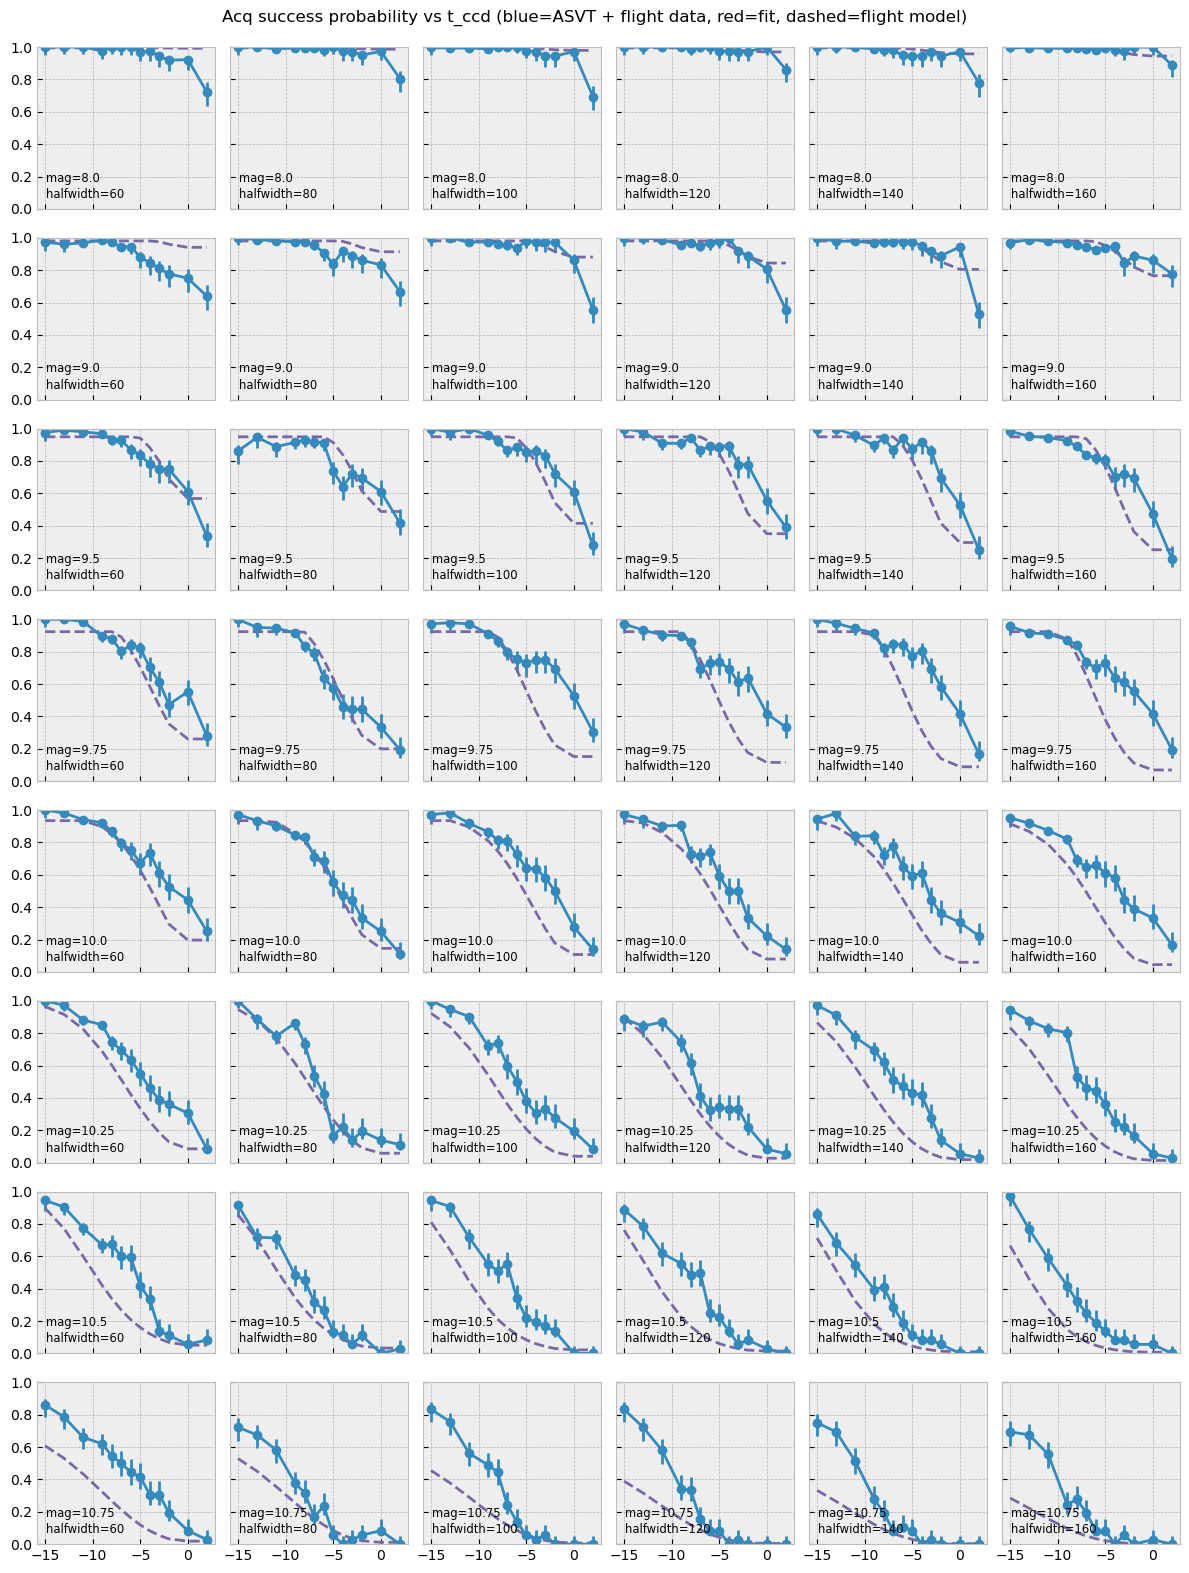

In [28]:
make_plots_grid(x_axis="t_ccd", x_grid="halfwidth", y_grid="mag", plot_p_fit=False)

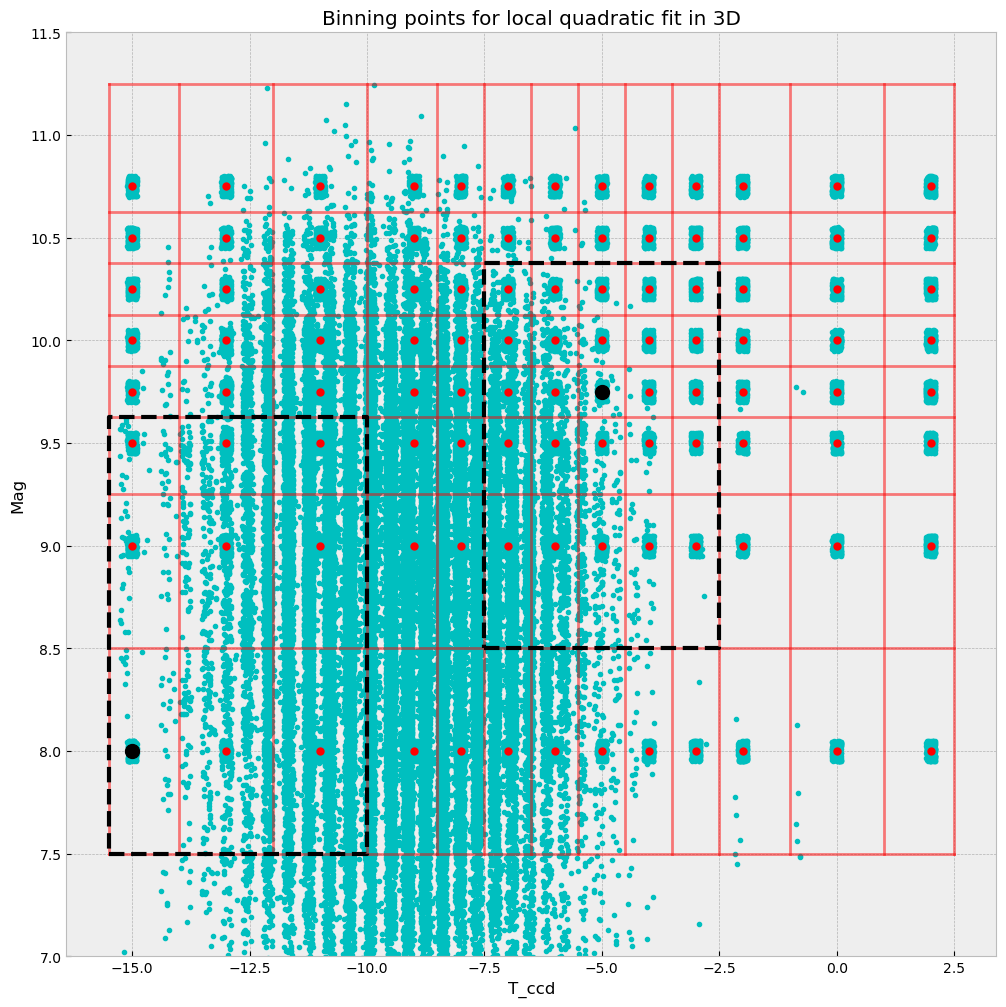

In [29]:
x = flt_asvt['t_ccd'] + np.random.uniform(-0.1, 0.1, len(flt_asvt))
y = flt_asvt['mag_aca'] + np.random.uniform(-0.05, 0.05, len(flt_asvt))
plt.figure(figsize=(12, 12))
plt.plot(x, y, '.', color='c')
plt.ylim(7.0, 11.5);
for mag in mag_bins:
    plt.plot([t_ccd_bins[0], t_ccd_bins[-1]], [mag, mag], color='r', alpha=0.5)
for t_ccd in t_ccd_bins:
    plt.plot([t_ccd, t_ccd], [mag_bins[0], mag_bins[-1]], color='r', alpha=0.5)

x, y = np.meshgrid(t_ccd_vals, mag_vals, indexing='ij')
plt.plot(x, y, 'o', color='r', markersize=5)

# CoPilot note:
# I typed: "plt.plot([-15.5, -10, -10,"" and CoPilot gave the rest with small corrections
plt.plot([-15.5, -10, -10, -15.5, -15.5], [7.5, 7.5, 9.625, 9.625, 7.5], '--', color='k', lw=3)
plt.plot([-7.5, -2.5, -2.5, -7.5, -7.5], [8.5, 8.5, 10.375, 10.375, 8.5], '--', color='k', lw=3)
plt.plot([-15, -5], [8.0, 9.75], 'o', color='k', markersize=10)

plt.xlabel('T_ccd')
plt.ylabel('Mag')
plt.title('Binning points for local quadratic fit in 3D');

In [30]:
def as_table(arr, fmt=None):
    """Turn one of the summary arrays into a readable table"""
    t = Table()
    t["mag"] = [str(val) for val in mag_vals]
    names = [f"{t_ccd:.1f}" for t_ccd in t_ccd_vals]
    for jj, name in enumerate(names):
        t[name] = arr[:, jj]
        if fmt:
            t[name].info.format = fmt
    return t


In [31]:
as_table(n_samp[:, :, -1])

mag,-15.0,-13.0,-11.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,0.0,2.0
str5,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
8.0,64,695,2847,4305,2670,1481,464,180,57,38,36,36,36
9.0,67,872,3666,5497,3487,2009,531,225,60,38,36,36,36
9.5,63,443,1700,2554,1375,620,134,77,37,36,36,36,36
9.75,47,230,720,825,329,132,50,41,36,36,36,36,36
10.0,42,123,246,217,117,65,44,36,36,36,36,36,36
10.25,37,57,81,66,49,41,36,36,36,36,36,36,36
10.5,36,43,46,43,37,36,37,36,36,36,36,36,36
10.75,36,37,36,37,36,36,36,36,36,36,36,36,36


In [32]:
def get_successes_slice(
    dat: Table,
    mag0=None,
    mag1=None,
    t_ccd0=None,
    t_ccd1=None,
    halfwidth0=None,
    halfwidth1=None,
):
    """Return a slice of the acq stats data table with the specified ranges."""
    ok = np.ones_like(dat["mag_aca"], dtype=bool)
    if mag0 is not None:
        ok &= dat["mag_aca"] >= mag0
    if mag1 is not None:
        ok &= dat["mag_aca"] < mag1
    if t_ccd0 is not None:
        ok &= dat["t_ccd"] >= t_ccd0
    if t_ccd1 is not None:
        ok &= dat["t_ccd"] < t_ccd1
    if halfwidth0 is not None:
        ok &= dat["halfwidth"] >= halfwidth0
    if halfwidth1 is not None:
        ok &= dat["halfwidth"] < halfwidth1
    return dat[ok]


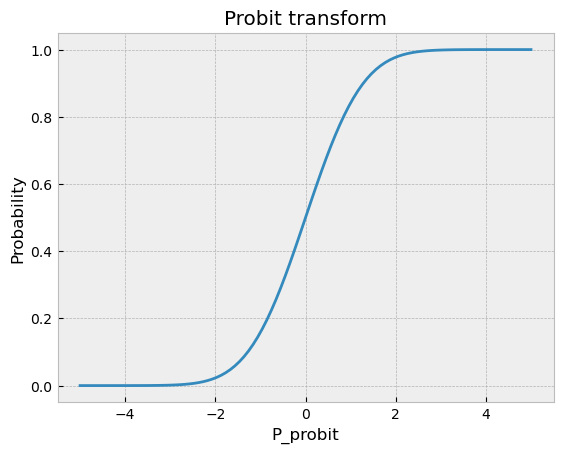

In [33]:
x = np.linspace(-5, 5, 100)
plt.plot(x, stats.norm.cdf(x));
plt.xlabel('P_probit')
plt.ylabel('Probability')
plt.title('Probit transform');

In [34]:
def calc_p_succ(pars, xs, x0s, order, as_probit=False):
    """
    Binomial probability model for N-d data

    Quadratic fit is of the form::

        dx0 = xs[0, :] - x0s[0]
        ...
        dxN-1 = xs[N-1, :] - x0s[N-1]
        p_probit = p0 * dx0 + p1 * dx0**2 + ... + p(2N+1)

    Parameters
    ----------

    pars : array-like
        Model parameters.  The last element is the intercept p(2N+1) and the previous 2N
        are the linear and quadratic coefficients for each of the N dimensions.
    xs : N x M array-like
        M data points in N dimensions
    x0s : N array-like
        Reference point for each dimension
    order : int
        Order of the polynomial fit.  Must be 1 or 2.
    as_probit : bool
        If True then return the probit probability.  If False then return probability.

    Returns
    -------
    prob : M array-like
        Probability of success for each of the M data points
    """
    xs = np.asarray(xs)
    x0s = np.asarray(x0s)

    p_succ_probit = pars[-1] * np.ones(shape=xs.shape[1:])

    for ii in range(len(x0s)):
        dx = (xs[ii, ...] - x0s[ii])
        if order == 1:
            p_succ_probit[...] += pars[ii] * dx
        elif order == 2:
            p_succ_probit[...] += pars[2 * ii] * dx + pars[2 * ii + 1] * dx ** 2
        else:
            raise ValueError(f"order={order} not supported")

    # Transform from probit to linear probability if user requested
    out = p_succ_probit if as_probit else stats.norm.cdf(p_succ_probit)

    return out


In [35]:
def calc_binom_stat(succ, p_succ):
    """
    Calculate log-likelihood for a binomial probability distribution.

    Defining p = model, then probability of seeing data == 1 is p and probability of
    seeing data == 0 is (1 - p). Probability of seeing the entire data set is the
    product of the probabilities of each data point.

    Note here that ``data`` is strictly either 0.0 or 1.0, and np.where interprets those
    float values as False or True respectively.

    Parameters
    ----------
    succ : array-like
        Array of successes (True or 1) or failures (False or 0)
    p_succ : array-like (same shape as ``succ``)
        Array of probabilities of success
    """
    bad = (p_succ < 0) | (p_succ > 1)
    if np.any(bad):
        raise ValueError(f"p_succ must be in the range 0 to 1 (got {p_succ[bad]})")
    # Clip to avoid log(0). Large probit values can result in p_succ = 1.0
    p_succ = p_succ.clip(1e-8, 1 - 1e-8)
    
    fit_stat = -np.sum(np.log(np.where(succ, p_succ, 1.0 - p_succ)))

    return fit_stat


In [36]:
def calc_fit_stat(pars, xs, x0s, succ, order):
    """Fitting statistic function for binomial probability model"""
    p_succ = calc_p_succ(pars, xs, x0s, order)
    fit_stat = calc_binom_stat(succ, p_succ)
    return fit_stat

## Example binomial fitting

In [37]:
xs = [np.random.uniform(0, 3, size=1000)]
x0s = [1.5]
pars = [1, 0.25]


In [38]:
p_succ = calc_p_succ(pars, xs, x0s, order=1)

In [39]:
succ = np.random.uniform(size=p_succ.shape) < p_succ

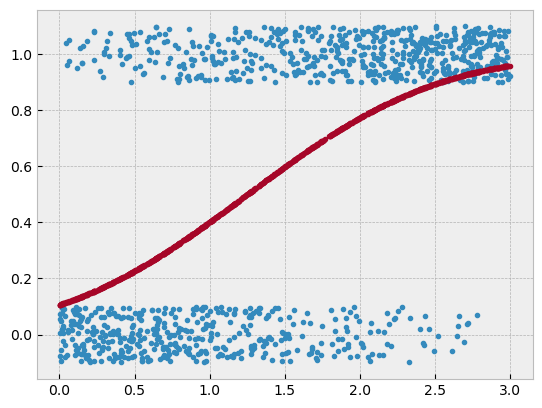

In [40]:
plt.plot(xs[0], succ + np.random.uniform(-0.1, 0.1, size=1000), '.')
plt.plot(xs[0], p_succ, '.');

In [41]:
calc_fit_stat(pars, xs, x0s, succ, order=1)

504.078219236524

In [42]:
calc_fit_stat([1, 1.0], xs, x0s, succ, order=1)

632.9206059002347

In [43]:
%time optimize.minimize(calc_fit_stat, [0.0, 0.0], args=(xs, x0s, succ, 1))

CPU times: user 8.02 ms, sys: 1.19 ms, total: 9.21 ms
Wall time: 8.19 ms


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 504.0210080614337
        x: [ 9.905e-01  2.621e-01]
      nit: 6
      jac: [-3.815e-06  3.815e-06]
 hess_inv: [[ 3.361e-03  4.823e-04]
            [ 4.823e-04  2.111e-03]]
     nfev: 24
     njev: 8

In [44]:
dok = get_successes_slice(
    flt_asvt,
    mag0=10.125,
    mag1=10.375,
    t_ccd0=-10,
    t_ccd1=-5,
    halfwidth0=55,
    halfwidth1=65,
)

In [45]:
np.mean(dok["obc_id"])


0.7711442786069652

In [46]:
len(dok)

402

In [47]:
%%time
xs = [dok['mag_aca'], dok['t_ccd']]
x0s = [8.0, -14.0]
res = optimize.minimize(calc_fit_stat, [0.0, 0.0, 0.0], args=(xs, x0s, dok['obc_id'], 1))
res

CPU times: user 15.3 ms, sys: 2.06 ms, total: 17.4 ms
Wall time: 15.6 ms


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 208.44742748826275
        x: [ 7.632e-01 -2.204e-01  3.388e-01]
      nit: 11
      jac: [-1.907e-06 -5.722e-06 -3.815e-06]
 hess_inv: [[ 1.415e+00  2.548e-03 -3.180e+00]
            [ 2.548e-03  3.210e-03 -2.489e-02]
            [-3.180e+00 -2.489e-02  7.264e+00]]
     nfev: 56
     njev: 14

In [48]:
from itertools import count

In [49]:
def iterbins(bin_edges, width, include_idxs=False):
    """
    Centers:     0   1   2   3   4   5   6   7   8   9
    Edges:     0   1   2   3   4   5   6   7   8   9   10
    width=1 answers:
       (0, 2), (0, 3), (1, 4) ...
    """
    i_min = 0
    i_max = len(bin_edges) - 1
    for i_center in range(len(bin_edges) - 1):
        i_edge0 = np.clip(i_center - width, i_min, i_max)
        i_edge1 = np.clip(i_center + width + 1, i_min, i_max)
        if include_idxs:
            out = i_center, i_edge0, i_edge1, bin_edges[i_edge0], bin_edges[i_edge1]
        else:
            out = i_center, bin_edges[i_edge0], bin_edges[i_edge1]
        yield out
        

In [50]:
print(mag_bins)
rows = []
for i_center, i_mag0, i_mag1, mag0, mag1 in iterbins(mag_bins, 2, include_idxs=True):
    rows.append((i_center, i_mag0, i_mag1, mag0, mag_vals[i_center], mag1))
t = Table(rows=rows, names=["i_center", "i_mag0", "i_mag1", "mag0", "mag_center", "mag1"])
t

[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


i_center,i_mag0,i_mag1,mag0,mag_center,mag1
int64,int64,int64,float64,float64,float64
0,0,3,7.5,8.0,9.625
1,0,4,7.5,9.0,9.875
2,0,5,7.5,9.5,10.125
3,1,6,8.5,9.75,10.375
4,2,7,9.25,10.0,10.625
5,3,8,9.625,10.25,11.25
6,4,8,9.875,10.5,11.25
7,5,8,10.125,10.75,11.25


In [51]:
n_succ.size

624

In [52]:
print(mag_vals)
print(mag_bins)

[ 8.    9.    9.5   9.75 10.   10.25 10.5  10.75]
[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


In [53]:
def calc_local_quadratic_fit():
    """
    Calculate a local quadratic fit for each bin in the mag, t_ccd, halfwidth

    Quadratic fit is of the form::

        p0 * (mag - mag0) + p1 * (mag - mag0)**2
        + p2 * (t_ccd - t_ccd0) + p3 * (t_ccd - t_ccd0)**2
        + p4 * (halfwidth - halfwidth0) + p5 * (halfwidth - halfwidth0)**2
        + p6

    Returns a tuple of:
    - p_fit_probit (model fit success as probit): 
        3D array of shape (n_mag, n_t_ccd, n_halfwidth)
    - P_succ (data success as probability): 
        3D array of shape (n_mag, n_t_ccd, n_halfwidth)

    (NOTE: CoPilot wrote most of this docstring)
    """
    p_fit_probit = np.zeros(shape=n_succ.shape, dtype=float)
    p_succ = np.zeros_like(p_fit_probit)

    for i_mag, mag0, mag1 in iterbins(mag_bins, width=2):
        mag = mag_vals[i_mag]
        print(f"{mag=} {i_mag=} ({mag0} to {mag1})")

        for i_t_ccd, t_ccd0, t_ccd1 in iterbins(t_ccd_bins, width=2):
            t_ccd = t_ccd_vals[i_t_ccd]

            for i_halfwidth, halfwidth0, halfwidth1 in iterbins(
                halfwidth_bins, width=2
            ):
                halfwidth = halfwidth_vals[i_halfwidth]
                # print(f"{halfwidth=} {i_halfwidth=} ({halfwidth0} to {halfwidth1})")
                dok = get_successes_slice(
                    flt_asvt,
                    mag0=mag0,
                    mag1=mag1,
                    t_ccd0=t_ccd0,
                    t_ccd1=t_ccd1,
                    halfwidth0=halfwidth0,
                    halfwidth1=halfwidth1,
                )
                xs = [dok["mag_aca"], dok["t_ccd"], dok["halfwidth"]]
                x0s = [mag, t_ccd, halfwidth]
                x_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                res = optimize.minimize(
                    calc_fit_stat,
                    x_init,
                    args=(xs, x0s, dok["obc_id"], 2),
                )
                p_succ0 = np.count_nonzero(dok["obc_id"]) / len(dok)
                p_fit_probit[i_mag, i_t_ccd, i_halfwidth] = res.x[-1]
                p_succ[i_mag, i_t_ccd, i_halfwidth] = p_succ0

    return p_fit_probit, p_succ


In [54]:
path = Path("p_fit_probit.npz")
if not path.exists():
    p_fit_probit, p_succ = calc_local_quadratic_fit()
    # CoPilot note:
    # Entered "np.savez" and CoPilot got the rest
    np.savez(path, p_fit_probit=p_fit_probit, p_succ=p_succ)    
else:
    # CoPilot note:
    # Wote "with" and CoPilot wrote the rest
    with np.load(path) as data:
        p_fit_probit = data["p_fit_probit"]
        p_succ = data["p_succ"]

In [55]:
p_fit = stats.norm.cdf(p_fit_probit)

In [56]:
# Print p_fit for mag_aca=10.75. Cols are halfwidth, rows are t_ccd
p_fit_probit[-1, :, :].round(3)

array([[ 1.247,  0.989,  0.942,  0.914,  0.744,  0.81 ],
       [ 0.844,  0.593,  0.525,  0.478,  0.362,  0.375],
       [ 0.478,  0.234,  0.145,  0.093, -0.051, -0.053],
       [ 0.178, -0.116, -0.225, -0.287, -0.486, -0.487],
       [ 0.056, -0.284, -0.43 , -0.533, -0.712, -0.757],
       [-0.066, -0.524, -0.702, -0.814, -0.976, -1.07 ],
       [-0.324, -0.876, -1.066, -1.138, -1.311, -1.378],
       [-0.54 , -1.164, -1.346, -1.437, -1.623, -1.601],
       [-0.784, -1.381, -1.56 , -1.692, -1.838, -1.823],
       [-0.861, -1.499, -1.675, -1.814, -2.048, -2.055],
       [-1.065, -1.614, -1.835, -2.077, -2.412, -2.418],
       [-1.376, -1.864, -2.095, -2.369, -2.835, -2.694],
       [-1.882, -2.287, -2.519, -2.926, -3.666, -3.345]])

In [57]:
# Print p_fit for mag_aca=10.75. Cols are halfwidth, rows are t_ccd
p_fit[-1, :, :].round(3)

array([[0.894, 0.839, 0.827, 0.82 , 0.772, 0.791],
       [0.801, 0.723, 0.7  , 0.684, 0.641, 0.646],
       [0.684, 0.593, 0.557, 0.537, 0.48 , 0.479],
       [0.571, 0.454, 0.411, 0.387, 0.314, 0.313],
       [0.522, 0.388, 0.334, 0.297, 0.238, 0.225],
       [0.474, 0.3  , 0.241, 0.208, 0.165, 0.142],
       [0.373, 0.191, 0.143, 0.127, 0.095, 0.084],
       [0.294, 0.122, 0.089, 0.075, 0.052, 0.055],
       [0.216, 0.084, 0.059, 0.045, 0.033, 0.034],
       [0.195, 0.067, 0.047, 0.035, 0.02 , 0.02 ],
       [0.143, 0.053, 0.033, 0.019, 0.008, 0.008],
       [0.084, 0.031, 0.018, 0.009, 0.002, 0.004],
       [0.03 , 0.011, 0.006, 0.002, 0.   , 0.   ]])

In [58]:
p_succ[-1].round(3)


array([[0.831, 0.822, 0.809, 0.785, 0.789, 0.768],
       [0.784, 0.774, 0.759, 0.725, 0.725, 0.705],
       [0.751, 0.738, 0.72 , 0.679, 0.677, 0.653],
       [0.693, 0.674, 0.65 , 0.594, 0.588, 0.557],
       [0.627, 0.6  , 0.571, 0.5  , 0.486, 0.454],
       [0.533, 0.502, 0.474, 0.395, 0.383, 0.355],
       [0.419, 0.39 , 0.368, 0.299, 0.296, 0.271],
       [0.318, 0.293, 0.277, 0.22 , 0.225, 0.207],
       [0.247, 0.227, 0.215, 0.168, 0.172, 0.16 ],
       [0.184, 0.171, 0.16 , 0.123, 0.129, 0.12 ],
       [0.14 , 0.128, 0.118, 0.089, 0.09 , 0.08 ],
       [0.12 , 0.109, 0.098, 0.075, 0.074, 0.064],
       [0.101, 0.089, 0.077, 0.057, 0.051, 0.042]])

In [59]:
len(flt_asvt)

78624

In [60]:
AXIS_LABELS = ["mag", "t_ccd", "halfwidth"]
X_VALS = [mag_vals, t_ccd_vals, halfwidth_vals]


In [61]:
p_succ_flt.shape

(8, 13, 6)

In [62]:
p_fit.shape

(8, 13, 6)

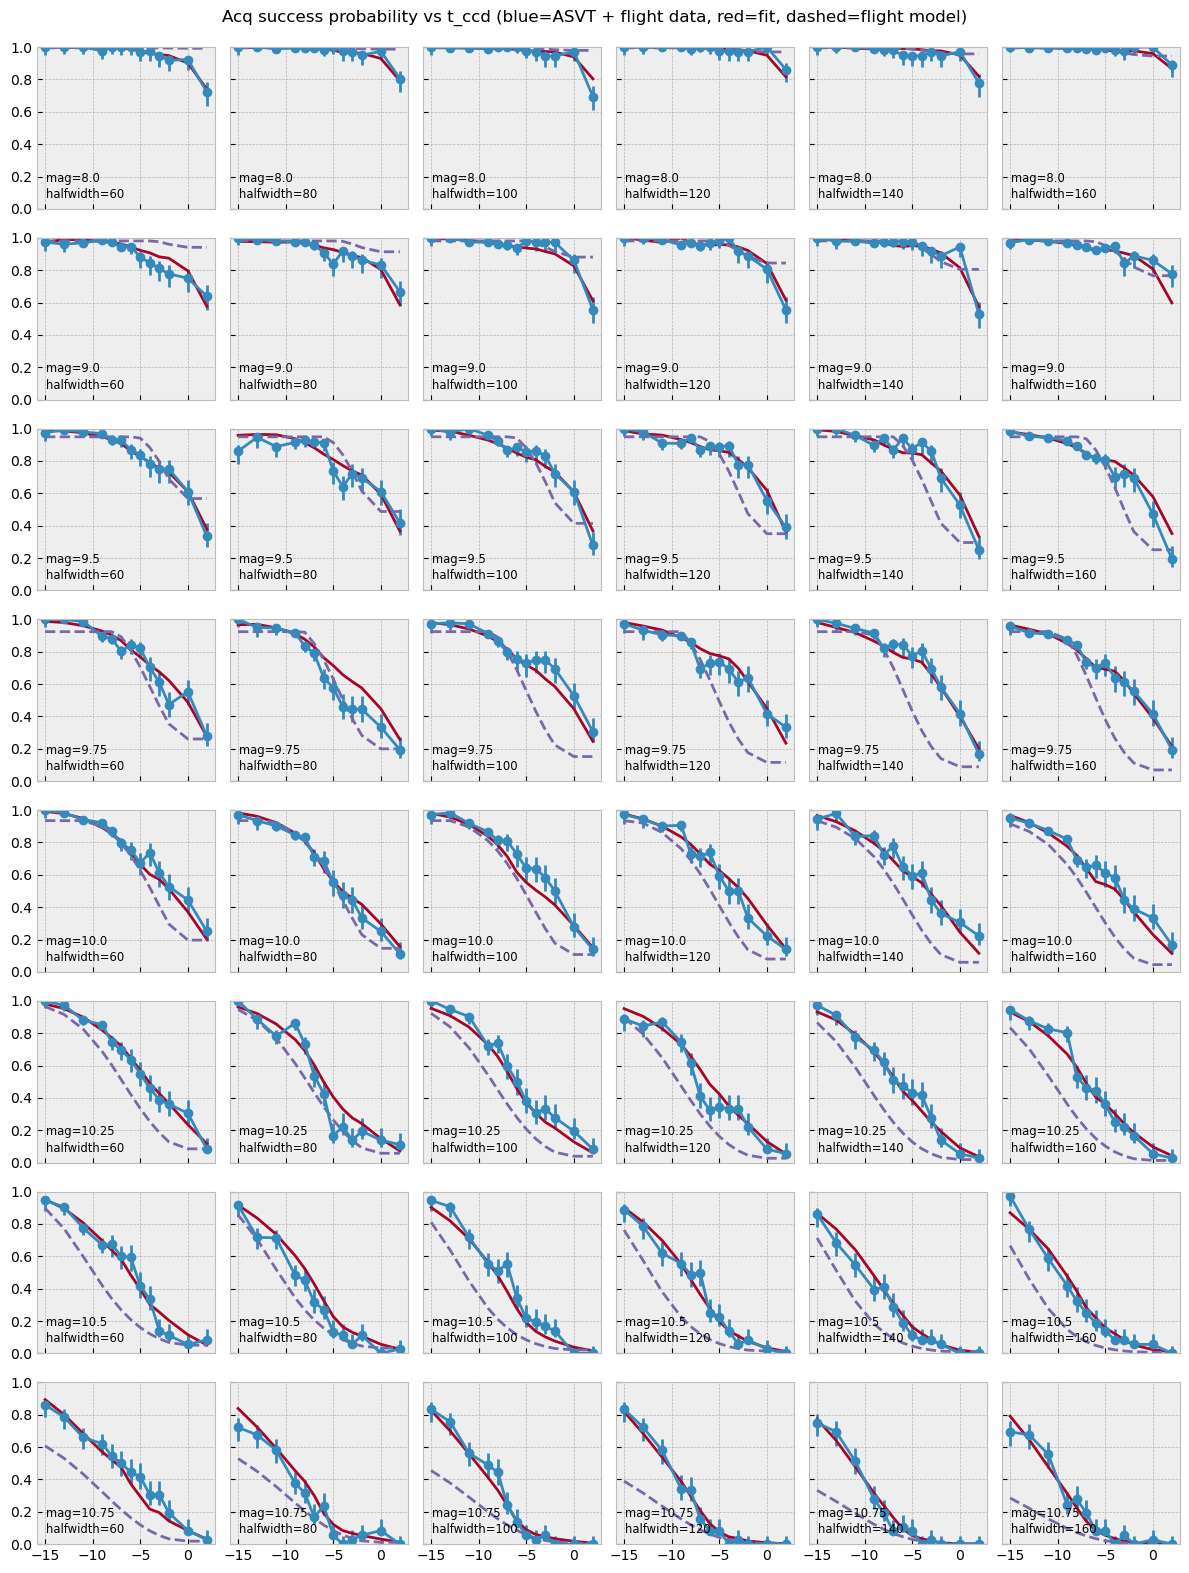

In [63]:
make_plots_grid(x_axis="t_ccd", x_grid="halfwidth", y_grid="mag")

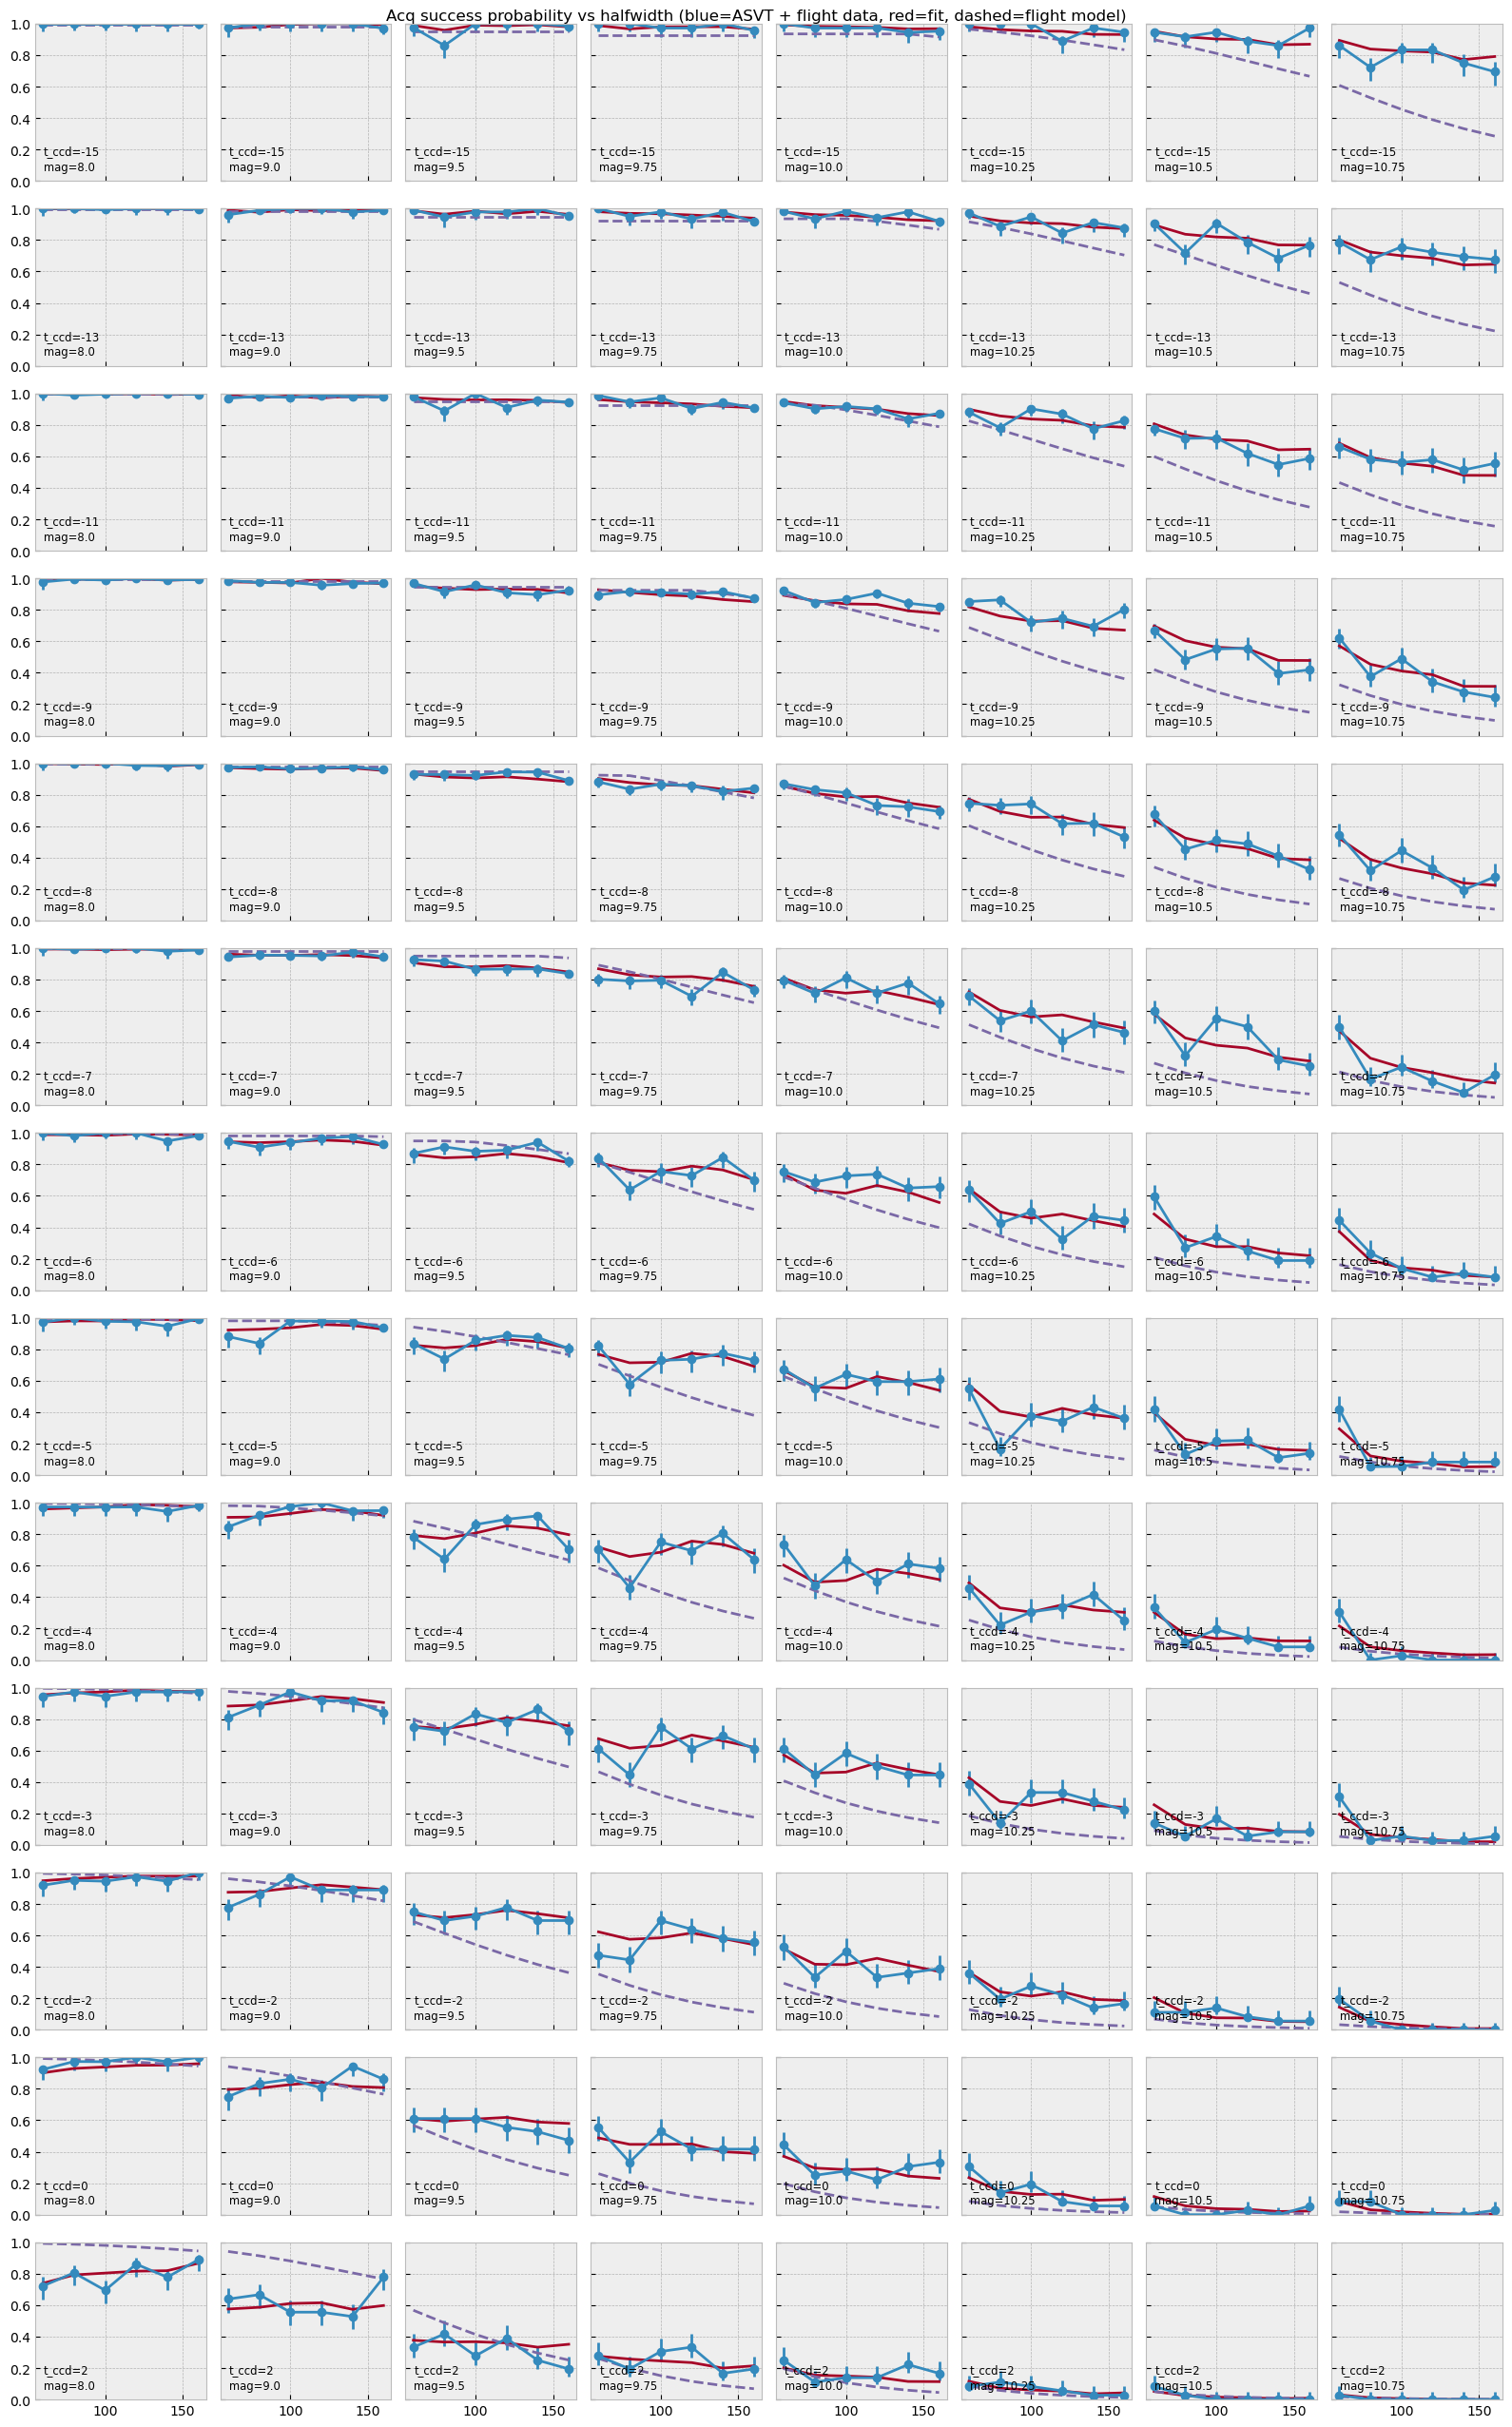

In [64]:
make_plots_grid(x_axis="halfwidth", x_grid="mag", y_grid="t_ccd")

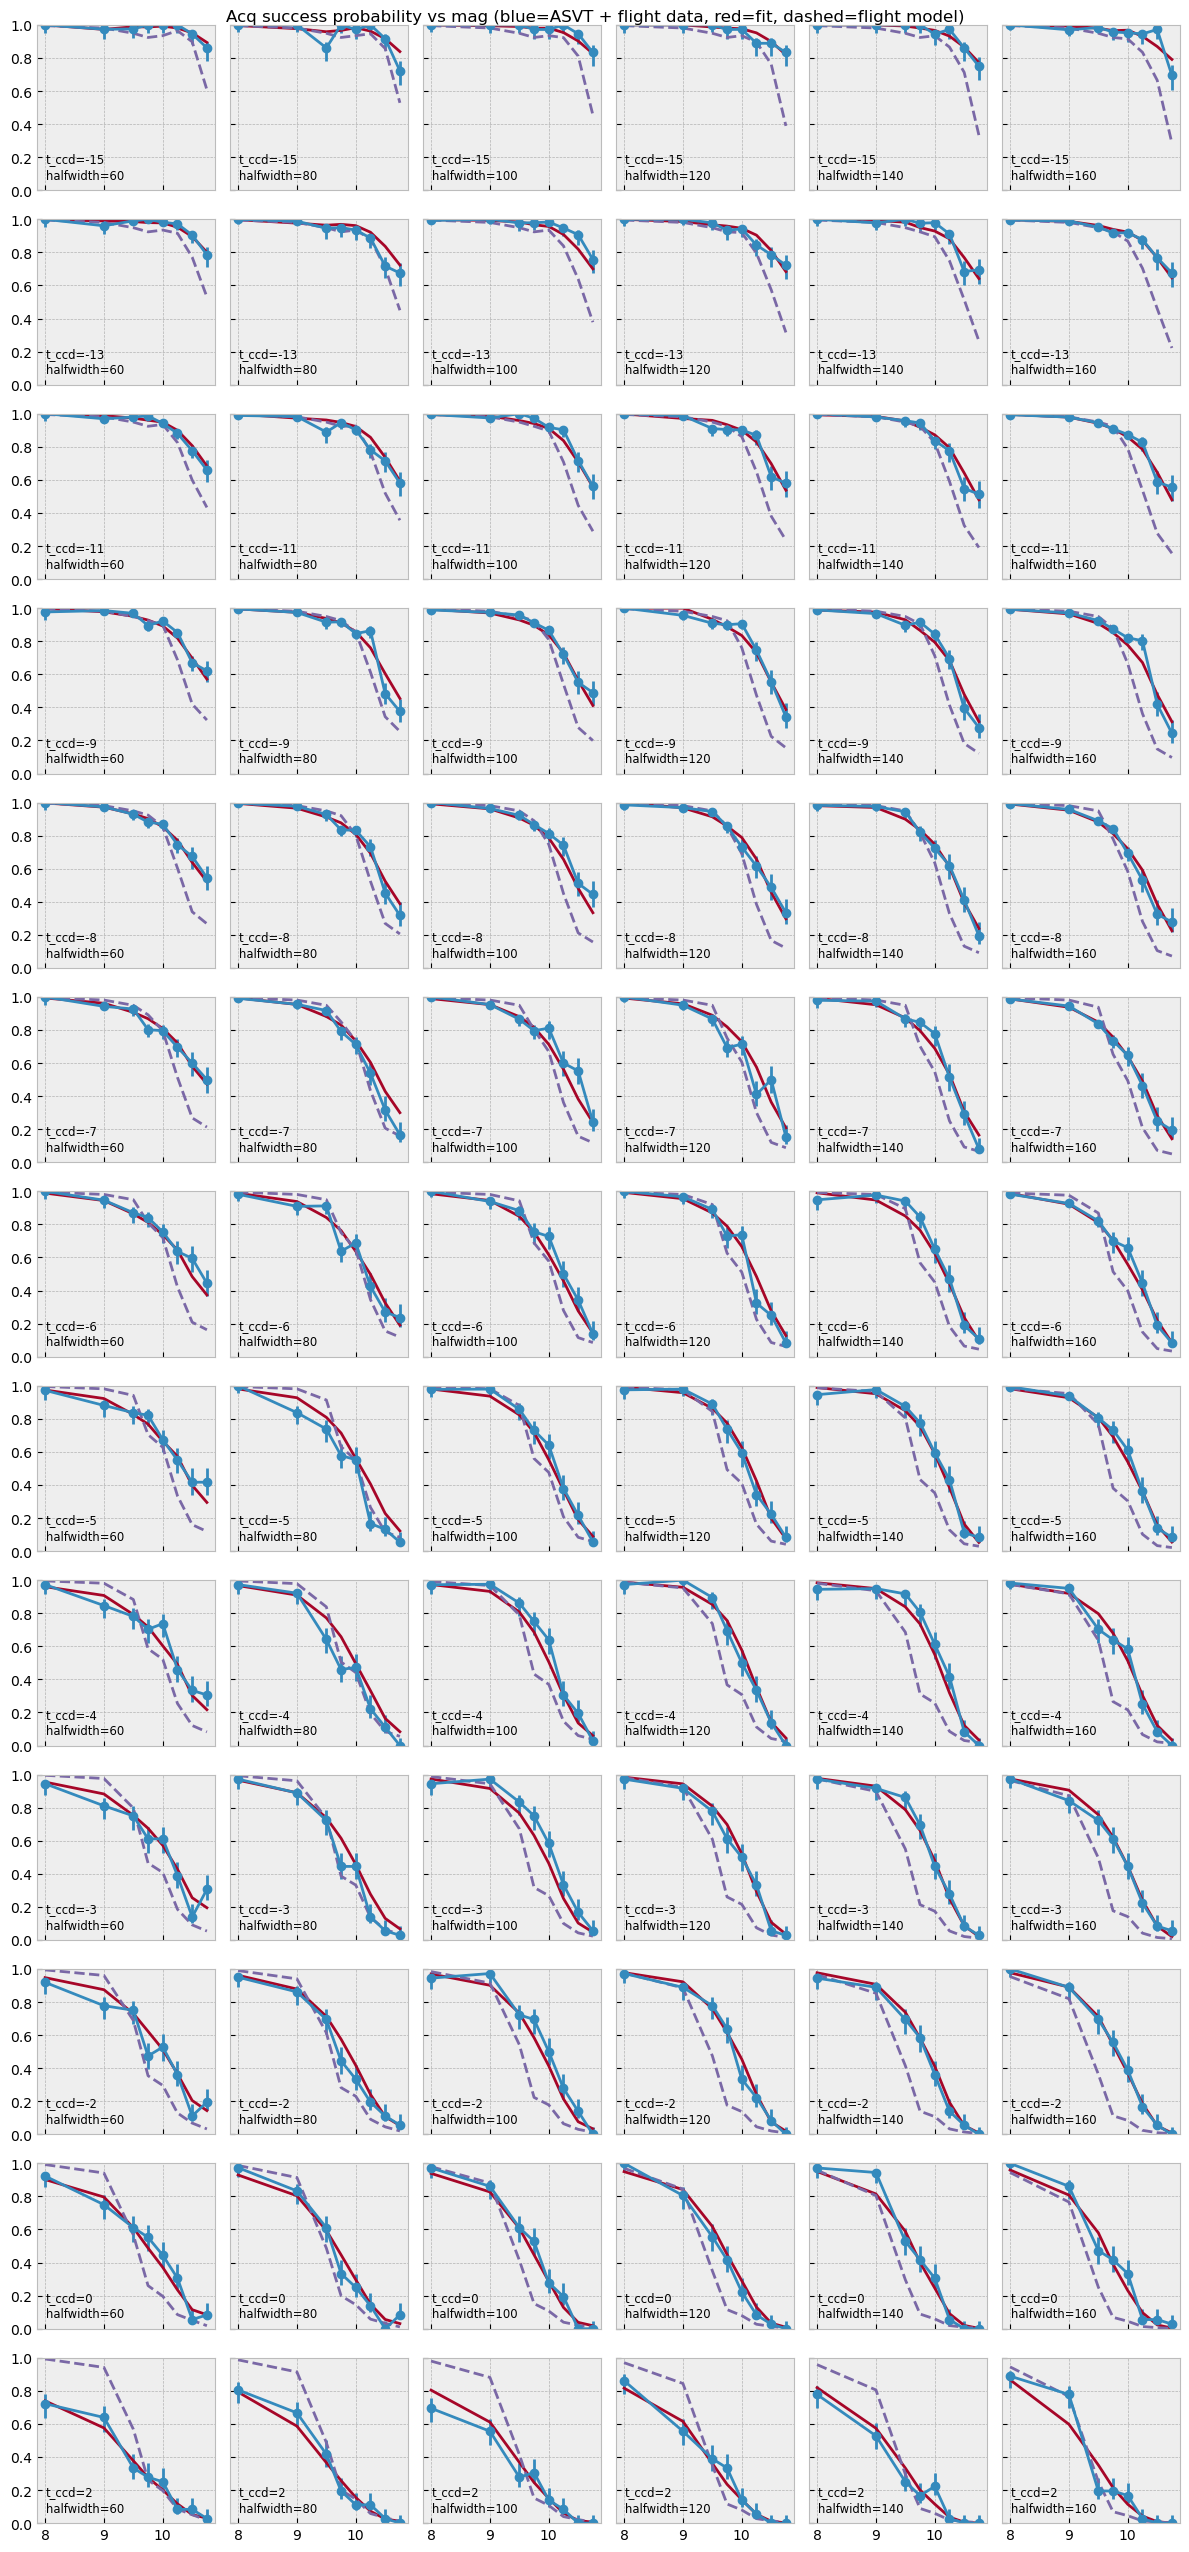

In [65]:
make_plots_grid(x_axis="mag", x_grid="halfwidth", y_grid="t_ccd")

## Acquisition probabilities for stars with COLOR=1.5

Stars in the catalog with a list color of exactly 1.5 are red stars where the
actual color is redder than 1.5. This clipping is an historical legacy that
will largely be removed with the next AGASC 1.8 release based on Gaia data.

These stars are currently about 10% of the selected guide stars. Importantly, in 
AGASC 1.7 they have a substantially different and non-Gaussian distribution of
magnitude errors. This has driven special handling and a separate acquisition
probability table.

In [66]:
# Get tables of all observed star mags and the AGASC entries for those stars
stars_obs = agasc.get_supplement_table("mags")
bad_stars = agasc.get_supplement_table("bad")
bad = np.isin(stars_obs["agasc_id"], bad_stars["agasc_id"]) | (
    stars_obs["mag_aca"] > 11.0
)
stars_obs = stars_obs[~bad]
stars_cat_1p8 = agasc.get_stars(
    stars_obs["agasc_id"],
    use_supplement=False,
    agasc_file="/Users/aldcroft/ska/data/agasc/agasc1p8rc1.h5",
)
stars_cat_1p7 = agasc.get_stars(
    stars_obs["agasc_id"],
    use_supplement=False,
)
c1p5 = np.isclose(stars_cat_1p7["COLOR1"], 1.5)
stars_cat_1p7 = stars_cat_1p7[c1p5]
stars_cat_1p8 = stars_cat_1p8[c1p5]

In [67]:
# Mags observed and from the AGASC 1.7 catalog
mags_obs = stars_obs["mag_aca"][c1p5]
mags_cat_1p7 = stars_cat_1p7["MAG_ACA"]
mags_cat_1p8 = stars_cat_1p8["MAG_ACA"]


In [68]:
# Number of color=1.5 and color != 1.5 stars in the catalog
print(np.count_nonzero(c1p5))
print(np.count_nonzero(~c1p5))

7490
83061


In [69]:
mag_obs_err_1p7 = mags_obs - mags_cat_1p7
mag_obs_err_1p8 = mags_obs - mags_cat_1p8

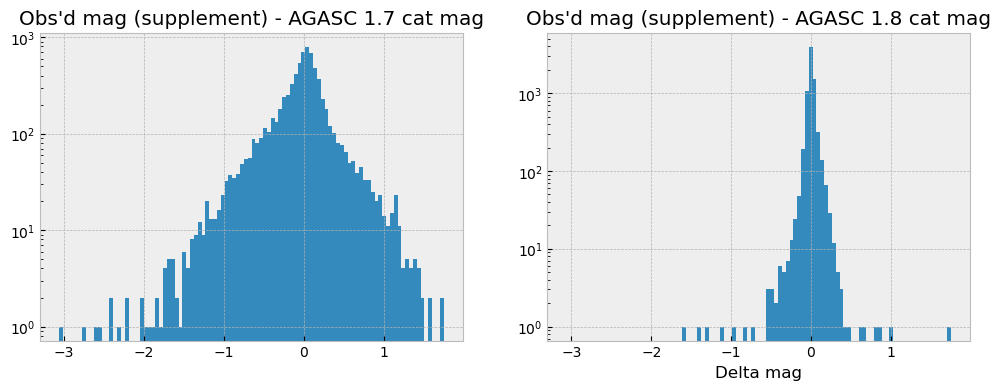

In [70]:
# Compare mag err distribution for color=1.5 stars in AGASC 1.7 and AGASC 1.8 rc1.
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
_, bins, _ = ax0.hist(mag_obs_err_1p7, bins=100, log=True);
_, bins, _ = ax1.hist(mag_obs_err_1p8, bins=bins, log=True);
ax0.set_title("Obs'd mag (supplement) - AGASC 1.7 cat mag");
ax1.set_title("Obs'd mag (supplement) - AGASC 1.8 cat mag");
ax1.set_xlabel('Delta mag');


## Probability values marginalized over mag error distribution

This is a potentially useful technique for AGASC 1.7 since the mag error
distribution for color=1.5 stars is broad and non-Gaussian. This technique has been 
used for the acquisition model for many years.

### Summary 

I propose dropping this technique and using the same probability values for red
color=1.5 stars as for the much large color < 1.5 stars.

### Details

This year I took a much more detailed look at the actual output probabilities and
noticed somewhat non-intuitive behavior: in some parts of the parameter space the
model for color=1.5 stars predicts a *higher* success rate. This is due to the
convolution of the probability curves and the long-tail mag error distribution.

In AGASC 1.7 there is a long tail of color=1.5 stars that are brighter than expected.
This can contribute to a mean probability that is higher by pulling in a number of
high probability cases at lower mags.

But on further examination this technique only makes a noticable difference for stars
fainter than about 10.0 mag (< 4% of color=1.5 stars since 2021). Even then the impact
is largest at cold temperatures that we rarely achieve any more. This is shown in the
plots below.

In [71]:
# Less than 4% of color=1.5 stars are fainter than 10.0 mag
recent = stars_obs["last_obs_time"][c1p5] > CxoTime("2021:001").secs
mags_obs_recent = stars_obs["mag_aca"][c1p5][recent]
print(np.count_nonzero(mags_obs_recent > 10.0))
print(np.count_nonzero(mags_obs_recent > 10.0) / len(mags_obs_recent))

60
0.03597122302158273


In [72]:
# Make a function that interpolates the fitted p_succ_probit(mag, t_ccd, halfwidth) 
# values which are defined on a regular grid.
from scipy.interpolate import RegularGridInterpolator

calc_p_succ_probit = RegularGridInterpolator(
    points=[mag_vals, t_ccd_vals, halfwidth_vals],
    values=p_fit_probit)

In [73]:
p_fit_1p5 = np.zeros_like(p_fit_probit)

In [74]:
def sample_p_succ(mag, t_ccd, halfwidth):
    """Sample the probability of acquisition success for `mag`, `t_ccd`, `halfwidth`.
    
    This adds observed error distribution in mag (from 7553 observed color=1.5 stars)
    for to the mag value and then returns the probability of acquisition success for
    that array of mag values.
    """
    mags = (mag + mag_obs_err_1p7)

    # Keep a record of mags that are outside the range of the model and then clip mags
    # to be within the range of the model.
    mag_too_high = mags > mag_vals[-1]
    mags = mags.clip(mag_vals[0], mag_vals[-1])

    # Create a list of points to interpolate.  These are the mag, t_ccd, halfwidth.
    points = [(mag_1p5, t_ccd, halfwidth) for mag_1p5 in mags]

    # Get the probit values for each point and then convert to probability values.
    vals_probit = calc_p_succ_probit(points)
    vals = stats.norm.cdf(vals_probit)

    # Any prob vals for mag > 10.75 are set to zero as a conservative estimate
    # that these stars are never acquired.
    vals[mag_too_high] = 0.0

    return vals


In [75]:
def plot_p_succ_distribution(mag=10.75, t_ccd=-15.0, halfwidth=60):
    p_succ_nom_probit = calc_p_succ_probit([mag, t_ccd, halfwidth])[0]
    p_succ_nom = stats.norm.cdf(p_succ_nom_probit)
    vals = sample_p_succ(mag, t_ccd, halfwidth)
    plt.hist(vals, bins=100, log=False);
    plt.axvline(p_succ_nom, color='C1', ls='--', label='nominal')
    plt.axvline(np.mean(vals), color='C4', ls='--', label='mean')
    plt.legend();

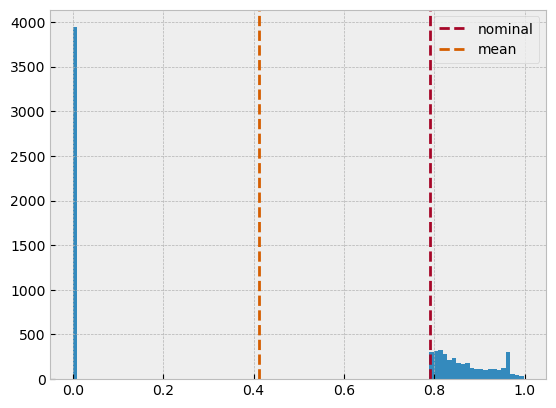

In [76]:
plot_p_succ_distribution(mag=10.75, t_ccd=-15.0, halfwidth=160)

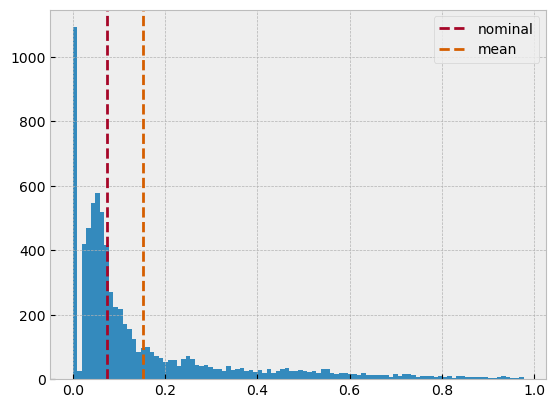

In [77]:
plot_p_succ_distribution(mag=10.5, t_ccd=-2.0, halfwidth=120)

In [78]:
for i_mag, mag in enumerate(mag_vals):
    print(f"{mag=} {i_mag=}")
    for i_t_ccd, t_ccd in enumerate(t_ccd_vals):
        for i_halfwidth, halfwidth in enumerate(halfwidth_vals):
            vals = sample_p_succ(mag, t_ccd, halfwidth)

            p_fit_1p5[i_mag, i_t_ccd, i_halfwidth] = np.mean(vals)

mag=8.0 i_mag=0
mag=9.0 i_mag=1
mag=9.5 i_mag=2
mag=9.75 i_mag=3
mag=10.0 i_mag=4
mag=10.25 i_mag=5
mag=10.5 i_mag=6
mag=10.75 i_mag=7


In [79]:
def plot_delta_p_fit_1p5(i_mag, fig, ax):
    # Plot image of difference with a colorbar.
    # Label the x-axis with halfwidth and y-axis with t_ccd
    # https://stackoverflow.com/questions/32462881/add-colorbar-to-existing-axis
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    mag = mag_vals[i_mag]
    dp_fit = (p_fit_1p5[i_mag, :, :] - p_fit[i_mag, :, :])
    vlim = max(abs(dp_fit.min()), abs(dp_fit.max()))
    vlim = max(vlim, 0.1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cax.grid(False)
    img = ax.imshow(dp_fit, origin="lower", cmap="RdBu_r", vmin=-vlim, vmax=vlim)
    fig.colorbar(img, cax=cax, orientation='vertical')
    ax.set_xticks(range(len(halfwidth_vals)), halfwidth_vals)
    ax.set_yticks(range(len(t_ccd_vals)), t_ccd_vals);
    ax.set_ylabel("t_ccd (degC)")
    ax.set_xlabel("halfwidth (arcsec)");
    ax.set_title(f"Mag={mag}", fontsize="medium");


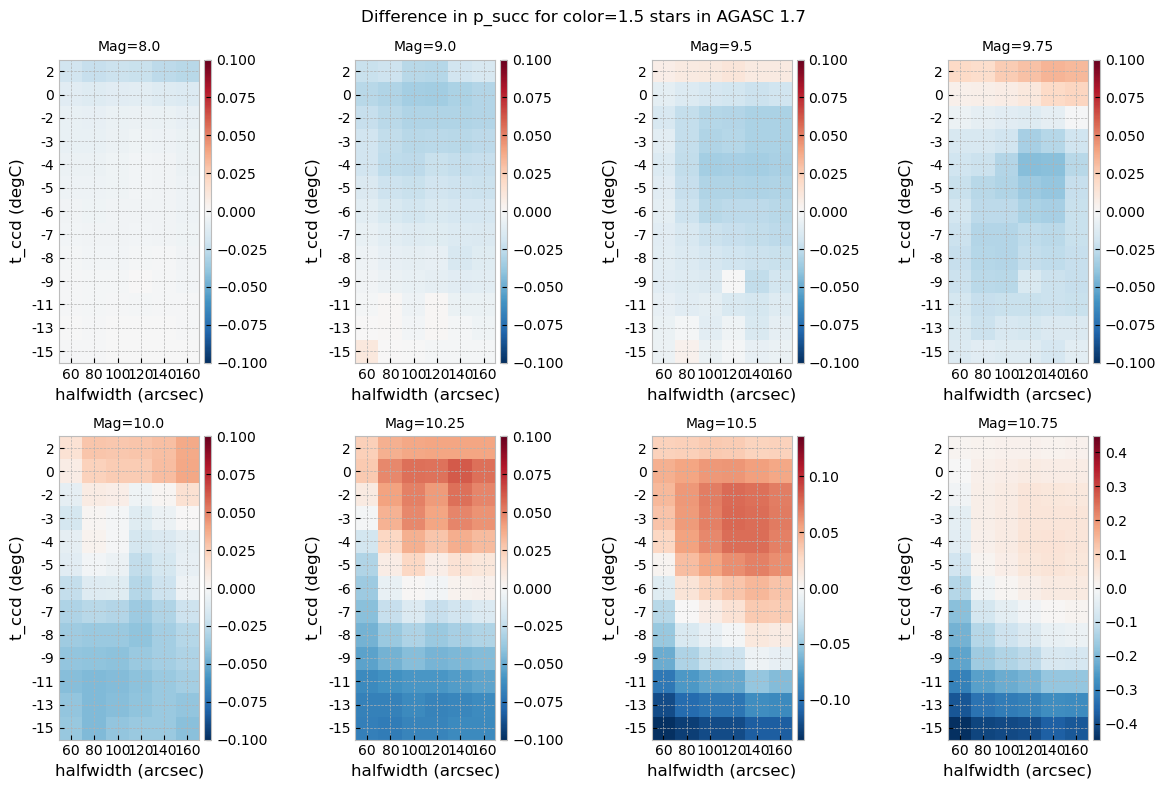

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
for i_mag, ax in enumerate(axes.flat):
    plot_delta_p_fit_1p5(i_mag, fig, ax)
fig.suptitle("Difference in p_succ for color=1.5 stars in AGASC 1.7");
fig.tight_layout()


## Write final model out as FITS in the standard format

In [81]:
def set_grid_axis_values(hdr, axis, vals):
    """Set grid model axis values for FITS header."""
    hdr[f"{axis}_n"] = len(vals)
    for ii, val in enumerate(vals):
        hdr[f"{axis}_{ii}"] = val
    hdr[f"{axis}_lo"] = vals[0]
    hdr[f"{axis}_hi"] = vals[-1]


In [82]:
# Succ prob for bright stars
ok = (flt["mag_aca"] > 5.2) & (flt["mag_aca"] < 7.5)
np.mean(flt['obc_id'][ok])

0.995417048579285

In [83]:
def add_bright_mags(arr):
    """Update p_succ to add p_succ = 0.993 values for bright mags.

    :param arr: p_succ_probit array
    """
    out = np.full(
        shape=(arr.shape[0] + 2, arr.shape[1], arr.shape[2]),
        fill_value=stats.norm.ppf(0.993),
    )
    out[2:, :, :] = arr
    return out

In [84]:
def write_model_as_fits(
    model_name,
    p_succ_probit,
    p_succ_1p5_probit,
    mags,
    t_ccds,
    halfws,
    comment=None,
):
    from astropy.io import fits

    # Sampling only goes to mag=8.0, so add bins for mag=5.0 and 7.0 with probability of
    # success of 99.3%. This matches general flight behavior for bright stars.
    mags = np.concatenate([[5.0, 7.0], mags])
    p_succ_probit = add_bright_mags(p_succ_probit)
    p_succ_1p5_probit = add_bright_mags(p_succ_1p5_probit)

    # COLOR not 1.5 (most stars)
    p_fails_probit = -p_succ_probit
    p_fails_1p5_probit = -p_succ_1p5_probit

    hdu = fits.PrimaryHDU()
    # if comment:
    #     hdu.header["comment"] = comment
    hdu.header["date"] = CxoTime().fits
    hdu.header["mdl_name"] = model_name
    set_grid_axis_values(hdu.header, "mag", mags)
    set_grid_axis_values(hdu.header, "t_ccd", t_ccds)
    set_grid_axis_values(hdu.header, "halfw", halfws)

    hdu1 = fits.ImageHDU(p_fails_probit.astype(np.float32))
    hdu1.header["comment"] = "COLOR1 != 1.5 (good mag estimates)"

    hdu2 = fits.ImageHDU(p_fails_1p5_probit.astype(np.float32))
    hdu2.header["comment"] = "COLOR1 == 1.5 (poor mag estimates)"

    hdus = fits.HDUList([hdu, hdu1, hdu2])
    print(f"Writing {model_name}.fits.gz...")
    hdus.writeto(f"{model_name}.fits.gz", overwrite=True)

In [85]:
comment = f"Created with fit_acq_model-{MODEL_DATE}-local-quadratic.ipynb in aca_stats repository"
write_model_as_fits(
    f"grid-local-quadratic-{MODEL_DATE}",
    p_fit_probit,
    p_fit_probit,  # Use same model for color=1.5 and color!=1.5
    mag_vals,
    t_ccd_vals,
    halfwidth_vals,
    comment=comment,
)

Writing grid-local-quadratic-2023-05.fits.gz...


In [91]:
!cp grid-local-quadratic-2023-05.fits.gz $SKA/data/chandra_models/chandra_models/aca_acq_prob

In [92]:
!ls -lrt $SKA/data/chandra_models/chandra_models/aca_acq_prob

total 592
-rw-r--r--  1 aldcroft  staff  144569 Feb 13 17:30 grid-floor-2020-02.fits.gz
-rw-r--r--  1 aldcroft  staff  146784 Feb 13 17:30 grid-floor-2018-11.fits.gz
-rw-r--r--  1 aldcroft  staff    3112 Apr 25 17:34 grid-local-quadratic-2023-02.fits.gz
-rw-r--r--  1 aldcroft  staff    3113 Apr 25 17:35 grid-local-quadratic-2023-05.fits.gz


In [93]:
mags, t_ccds, halfws = np.meshgrid(mag_vals, t_ccd_vals, halfwidth_vals, indexing="ij")

In [94]:
p_mods = star_probs.acq_success_prob(
    mag=mags, t_ccd=t_ccds, halfwidth=halfws, model="grid-local-quadratic-2023-05"
)

In [95]:
np.max(np.abs(p_mods - p_fit))

1.3233115769839543e-08